In [1]:
# Load data

import numpy as np
import pandas as pd
np.random.seed(seed=42)

df = pd.read_csv('./data/ml-latest-small/ratings.csv')
df = df[(1 <= df.userId) & (df.userId <= 20)]
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [2]:
# Convert to a rating matrix

ratings = df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
Y = ratings.to_numpy()
Y.shape

(20, 1859)

In [3]:
# Make User-Item matrix

User = Y.copy()
User -= User.mean()
User.shape

(20, 1859)

In [4]:
# Make Item-User matrix

Item = User.copy().T
Item.shape

(1859, 20)

In [5]:
# Bayesian GPVLM model

import GPy
import matplotlib.pyplot as plt

input_dim = 2

#kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.White(input_dim)
kernel = GPy.kern.RBF(input_dim, ARD=True)
model = GPy.models.BayesianGPLVM(Item, input_dim, kernel=kernel, num_inducing=30)
#model.optimize(messages=True, max_iters=1e3)

{'scatter': [<matplotlib.collections.PathCollection at 0x116b824e0>],
 'imshow': <matplotlib.image.AxesImage at 0x116b822e8>}

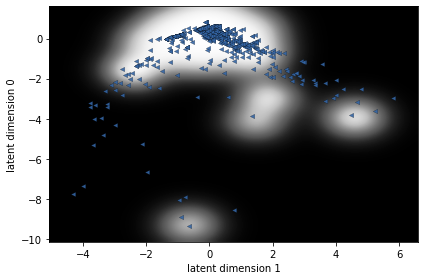

In [6]:
# Plot latent variables

model.plot_latent()

In [7]:
# Sampling from p(X) ~ N(mu, cov)

def sampling(user_id, model, n_sample=10000):
    X_mean = model.X.mean
    X_var = model.X.variance

    X_mean_i = X_mean[Y[user_id] != 0, :]
    X_var_i = X_var[Y[user_id] != 0, :]

    x_min = min(X_mean_i[:, 0])
    x_max = max(X_mean_i[:, 0])
    y_min = min(X_mean_i[:, 1])
    y_max = max(X_mean_i[:, 1])

    samples = []
    for n, mu in enumerate(X_mean_i):
        cov = np.diag(X_var_i[n])
        samples.append(np.random.multivariate_normal(mu, cov, n_sample*10))
    return np.vstack(samples).T


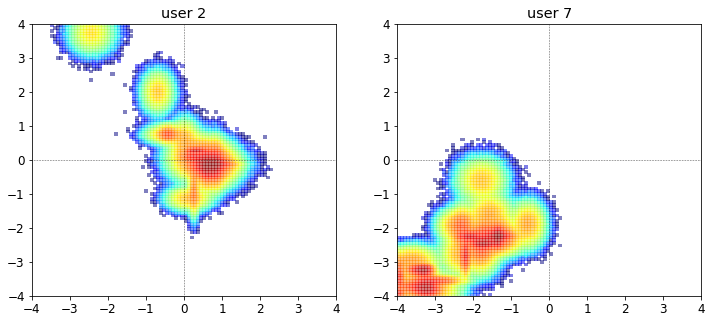

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_users(user_1, user_2):
    xy_lim = np.array([(-4, 4), (-4, 4)])
    plt.rcParams["font.size"] = 12
    
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)

    x1, y1 = sampling(user_1, model)
    axL.hist2d(x1, y1, bins=100, range=xy_lim, cmap='jet', alpha=0.5, norm=LogNorm())
    axL.hlines(0, -4, 4, linestyles='dotted', linewidth=0.6)
    axL.vlines(0, -4, 4, linestyles='dotted', linewidth=0.6)
    axL.set_title('user %s' % (user_1))

    x2, y2 = sampling(user_2, model)
    axR.hist2d(x2, y2, bins=100, range=xy_lim, cmap='jet', alpha=0.5, norm=LogNorm())
    axR.hlines(0, -4, 4, linestyles='dotted', linewidth=0.6)
    axR.vlines(0, -4, 4, linestyles='dotted', linewidth=0.6)
    axR.set_title('user %s' % (user_2))

    plt.show()    

plot_users(2, 7)

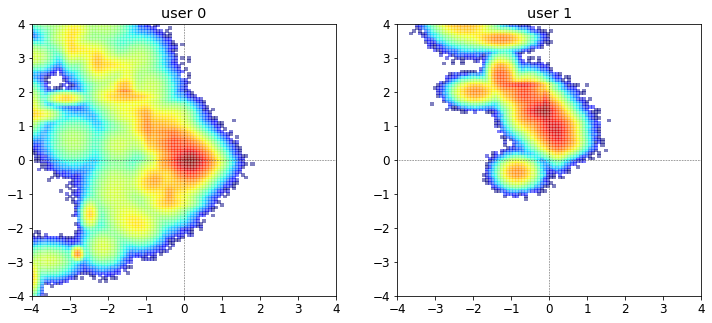

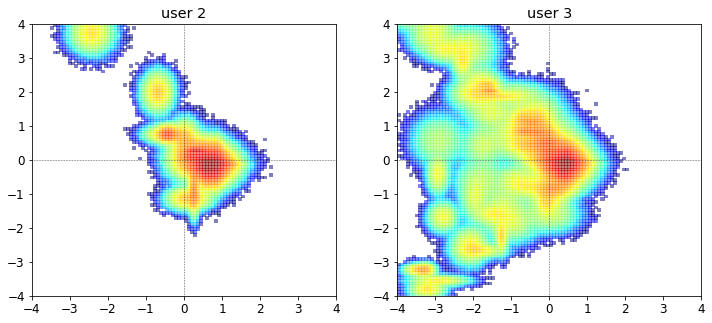

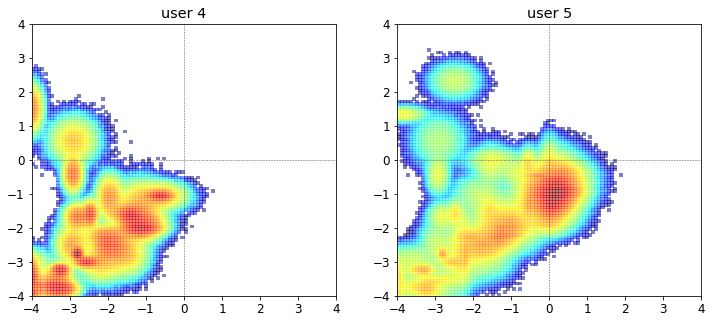

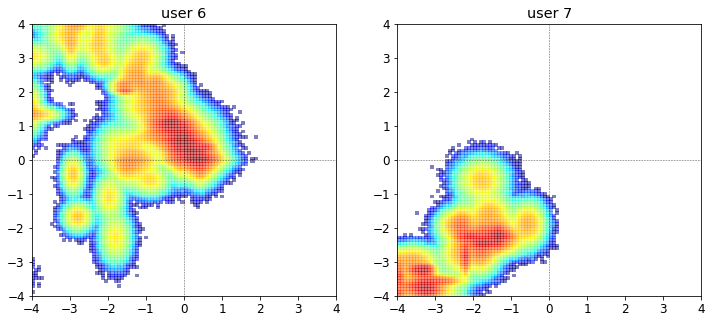

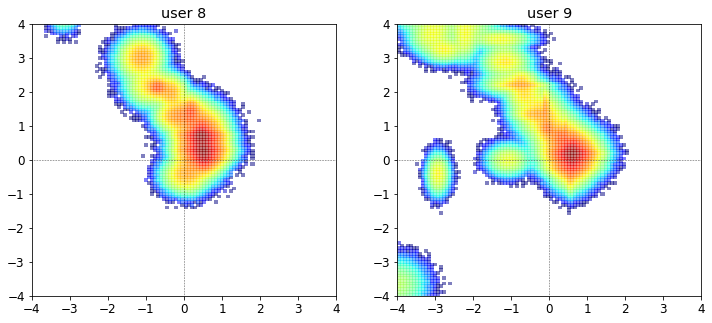

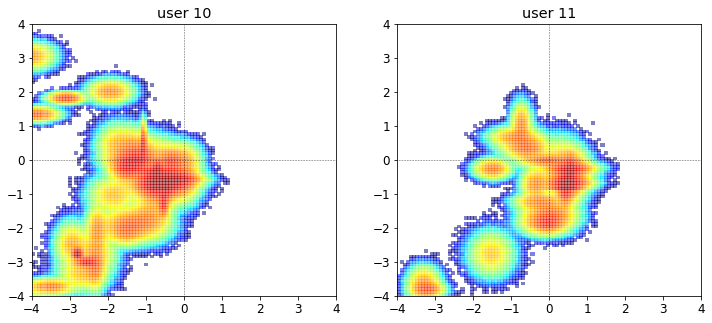

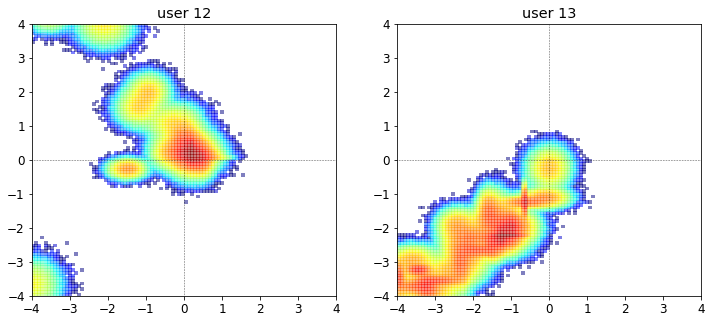

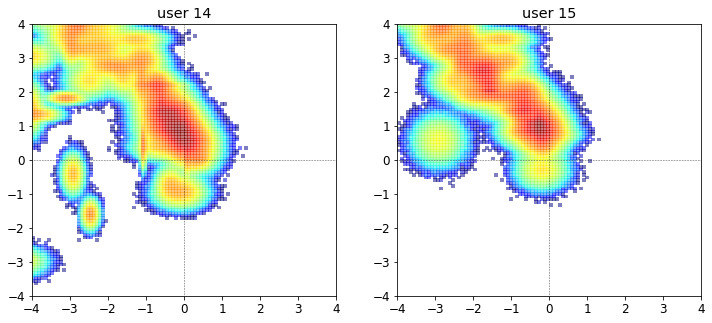

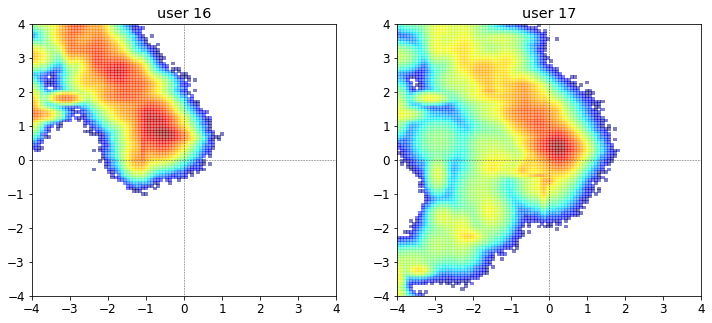

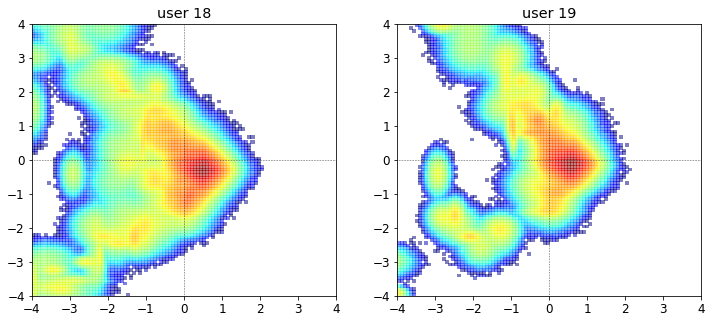

In [9]:
# Plot 
for i in range(0, df.userId.nunique(), 2):
    plot_users(i, i+1)    